In [ ]:
# Basis-Imports (oben)
import sys
import gc
import time
import asyncio
import numpy as np

# Abschnitts-spezifisch (in der Zelle, wo es gebraucht wird)
# from numba import njit
# import pymc as pm

## 1. Memory Management: Refernce Counting & Zyklischer GC

Python nutzt ein Hybrid-System. Das Reference Counting (RC) löscht sofort, der Cyclic GC kümmert sich um die "toten Inseln".

In [1]:
class Elephant:
    pass  # leere Klasse (Platzhalter)


e1 = Elephant()
print(f"Initialer Counter: {sys.getrefcount(e1) - 1}")

e2 = e1
print(f"Nach Zuweisung e2: {sys.getrefcount(e1) - 1}")

del e2
print(f"Nach del e2: {sys.getrefcount(e1) - 1}")

Initialer Counter: 1
Nach Zuweisung e2: 2
Nach del e2: 1


**Hintergrund**: In C# würde der GC das Objekt irgendwann abholen. In Python bleibt es ohne den zyklischen GC ewig im Speicher, da der Reference Count bei 1 (gegenseitige Referenz) stehen bleibt.

**Aufgabe:** Erstellen Sie zwei Instanzen einer Klasse Node, die sich gegenseitig referenzieren. Beweisen Sie mit gc.collect(), dass sie erst durch den zyklischen GC gelöscht werden.

**Lösung**:

In [2]:
# import gc

# SOLUTION
class Node:
    def __init__(self, name):
        self.name = name
        self.link = None

    def __del__(self):
        print(f"🗑️ Lösche {self.name} aus dem RAM")


def create_cycle():
    a = Node("Elefant_A")
    b = Node("Elefant_B")
    a.link = b
    b.link = a
    print("Zyklus erstellt.")


create_cycle()
print("Funktion beendet. Objekte existieren dank Zyklus noch!")
print(f"GC-Status: {gc.collect()} Objekte bereinigt.")  # Hier wird gelöscht

Zyklus erstellt.
Funktion beendet. Objekte existieren dank Zyklus noch!
🗑️ Lösche Elefant_A aus dem RAM
🗑️ Lösche Elefant_B aus dem RAM
GC-Status: 1055 Objekte bereinigt.


## 2. GIL & Multi-Core: Das Nadelöhr

In C# nutzen wir alle Kerne. In Python verhindert das Global Interpreter Lock, dass zwei Threads gleichzeitig Python-Bytecode ausführen.

In [3]:
def heavy_task():
    # Eine CPU-intensive Berechnung
    return sum(i * i for i in range(10**7))


# Messen Sie die Zeit für 2x heavy_task() sequenziell vs. 2 Threads vs. 2 Prozesse.
# Spoileralarm: Threads bringen hier keinen Speedup!

**Aufgabe**: Beweise, dass Multi-Threading bei CPU-Last in Python nicht skaliert, Multi-Processing hingegen schon.

**Hintergrund**: Threads brauchen ca. die gleiche Zeit wie sequenziell (oder länger wegen Overhead). Prozesse skalieren fast linear mit der Anzahl der Kerne.

**Lösung**:

In [2]:
# import time
from threading import Thread
from multiprocessing import Process


def benchmark(worker_class):
    print(f"Starte Test mit: {worker_class.__name__}")
    start_time = time.perf_counter()

    # 1. Erzeugen der Worker-Objekte
    workers = [worker_class(target=heavy_task) for _ in range(2)]

    # 2. START-Schleife: Alle Worker so schnell wie möglich losschicken
    for w in workers:
        w.start()

    # 3. JOIN-Schleife: Sicherstellen, dass alle fertig sind, bevor wir die Zeit stoppen
    for w in workers:
        w.join()

    end_time = time.perf_counter()
    print(f"Dauer: {end_time - start_time:.2f} Sekunden\n")


# Testlauf
if __name__ == "__main__":
    benchmark(Thread)  # Wird durch das GIL ausgebremst (ca. doppelt so lang wie 1 Kern)
    benchmark(Process)  # Nutzt 2 echte Kerne (sollte deutlich schneller sein)

Starte Test mit: Thread
Dauer: 3.60 Sekunden

Starte Test mit: Process
Dauer: 0.35 Sekunden



## 3. Asyncio: Der flinke Kellner

Warum 10.000 Tasks besser sind als 10.000 Threads.

**Aufgabe**: Simuliere das gleichzeitige Abrufen von 50 Sensordaten-Paketen (I/O-bound), ohne 50 Sekunden warten zu müssen.

**Lösung**:

In [6]:
# import asyncio

# SOLUTION
async def fetch_sensor(id):
    await asyncio.sleep(1)  # Simuliert Netzwerk-Verzögerung
    return f"Daten von Sensor {id}"


async def main():
    start = time.perf_counter()
    # Führt alle 50 Aufrufe quasi-parallel in einem Thread aus
    # results = await asyncio.gather(*(fetch_sensor(i) for i in range(50)))
    print(f"50 Sensoren gelesen in {time.perf_counter() - start:.2f}s")


# In Jupyter einfach:
await main()

50 Sensoren gelesen in 1.01s


## 4. NumPy: Vektorisierung & SIMD

Warum for-Schleifen in Python "böse" sind (wenn es um Mathe geht).

In [ ]:
# import numpy as np

data = np.random.rand(10**7)

# Vergleichen Sie:
# 1. [x**2 for x in data] (Listen-Abstraktion)
# 2. np.square(data) (Vektorisierung)

**Hintergrund**: NumPy nutzt intern hochoptimierte C-Schleifen und SIMD-Register der CPU.

**Aufgabe**: Berechne das Quadrat von 1 Million Werten und vergleiche die Geschwindigkeit einer Python-Schleife mit einer NumPy-Operation.

**Lösung**: Vektorisierung vs. Liste

In [7]:
# import numpy as np
# import time

data = np.random.rand(10**7)
data_list = data.tolist()

# 1. Liste (Langsam)
start = time.perf_counter()
res_list = [x**2 for x in data_list]
print(f"Liste: {time.perf_counter() - start:.4f}s")

# 2. NumPy (Schnell)
start = time.perf_counter()
res_np = data**2
print(f"NumPy: {time.perf_counter() - start:.4f}s")

Liste: 1.9576s
NumPy: 0.0215s


## 5. Metaprogrammierung: Code, der Code schreibt

Wir nutzen Decorators, um unsere API-Aufrufe im Projekt zu schützen.

🧪 Experiment: Der @log_access Decorator

In [ ]:
def log_access(func):
    def wrapper(*args, **kwargs):
        print(f"Audit-Log: Zugriff auf {func.__name__}")
        return func(*args, **kwargs)

    return wrapper


@log_access
def get_elephant_secret():
    return "Elefanten vergessen nie."


print(get_elephant_secret())

**Aufgabe**: Implementiere einen Decorator @require_admin, der Funktionen schützt und nur den Zugriff erlaubt, wenn der Parameter user='admin' übergeben wird.

**Lösung**:

In [8]:
# SOLUTION
def require_admin(func):
    def wrapper(*args, **kwargs):
        user = kwargs.get("user") or (args[0] if args else None)
        if user != "admin":
            return "🚫 Zugriff verweigert!"
        return func(*args, **kwargs)

    return wrapper


@require_admin
def delete_database(user):
    return "💥 Datenbank gelöscht."


print(delete_database(user="student"))  # Verweigert
print(delete_database(user="admin"))  # Erlaubt

🚫 Zugriff verweigert!
💥 Datenbank gelöscht.


## 6. Numba JIT: Python bei Lichtgeschwindigkeit

Wenn NumPy nicht reicht, kompilieren wir Python-Code zur Laufzeit in Maschinencode.

🧪 Experiment: Die Monte-Carlo-Pi-Simulation

π ≈ 4⋅Punkte im Quadrat / Punkte im Kreis

In [9]:
from numba import njit


@njit
def fast_pi(n):
    acc = 0
    for i in range(n):
        if random.random() ** 2 + random.random() ** 2 < 1.0:
            acc += 1
    return 4.0 * acc / n

**Aufgabe**: Beschleunige eine mathematisch aufwendige Funktion (z.B. Monte Carlo Pi), die in reinem Python zu langsam wäre.

**Lösung**: Monte Carlo Pi mit Numba

In [10]:
import random

# Warmup
fast_pi(1)

# Benchmark
start = time.perf_counter()
print(f"Pi ist ca. {fast_pi(10**7)}")
print(f"Zeit mit Numba: {time.perf_counter() - start:.4f}s")

Pi ist ca. 3.1408676
Zeit mit Numba: 0.2363s


**Ergebnis**: Beim ersten Aufruf kompiliert Numba den Code (LLVM), danach läuft er fast so schnell wie C++.

## 7. Probabilistische Programmierung (PyMC)

Unsicherheit ist eine Information, kein Fehler. Wenden Sie die Bayesianische Schätzung an.

In [11]:
import pymc as pm

with pm.Model() as model:
    # Wir schätzen das Gewicht eines Elefanten
    weight = pm.Normal("weight", mu=5000, sigma=500)
    # ... Inferenz-Code hier ...

C:\Users\sebastian.bichler\OneDrive - IU International University of Applied Sciences\ProgProjects\IU_Python\IU_2026_EF_LE_BER_VC_Python\.venv\Lib\site-packages\arviz\__init__.py:39: FutureWarning: 
ArviZ is undergoing a major refactor to improve flexibility and extensibility while maintaining a user-friendly interface.
Some upcoming changes may be backward incompatible.
For details and migration guidance, visit: https://python.arviz.org/en/latest/user_guide/migration_guide.html
  warn(


**Hintergrund**: Das Modell liefert eine Wahrscheinlichkeitsverteilung für das wahre Gewicht des Elefanten.

**Aufgabe**: Schätze das Durchschnittsgewicht einer Elefantenherde basierend auf 5 ungenauen Messungen.

**Lösung**: Bayesianische Schätzung

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


<Axes: title={'center': 'mu'}>

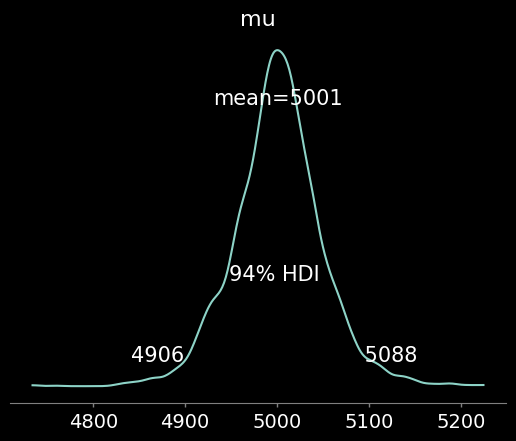

In [12]:
import pymc as pm
import arviz as az

# Beobachtete Gewichte (mit Messfehlern)
obs_weights = [4950, 5020, 5100, 4880, 5050]

with pm.Model() as model:
    # Wir vermuten das Gewicht um 5000kg (Prior)
    mu = pm.Normal("mu", mu=5000, sigma=500)
    sigma = pm.HalfNormal("sigma", sigma=100)

    # Likelihood
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=obs_weights)

    # Sampling
    trace = pm.sample(1000, return_inferencedata=True, progressbar=False)

# Visualisierung für die Studierenden
az.plot_posterior(trace, var_names=["mu"])

## 8. Structural Design Patterns: Adapter

Dank Duck Typing sind Patterns in Python oft nur eine einfache Klasse ohne Interfaces.

🧪 Experiment: Der GPS-Adapter

**Aufgabe**: Unser System erwartet GPS-Daten als Dictionary über die Methode get_coordinates(). Ein neuer Sensor-Typ liefert die Daten jedoch als Roh-String über eine Methode namens fetch_raw_data(). Baue einen Adapter, um den neuen Sensor ohne Änderung am restlichen Code zu integrieren.

**Lösung**:

In [3]:
# --- DAS BESTEHENDE SYSTEM ---


class LegacyGPSSensor:
    """Der Standard-Sensor im Projekt."""

    def get_coordinates(self):
        return {"lat": 51.31, "lon": 12.37}


# --- DIE NEUE, INKOMPATIBLE KLASSE ---


class NewHighTechSensor:
    """Ein neuer Sensor eines Drittanbieters mit anderer API."""

    def fetch_raw_data(self):
        # Liefert Daten als String statt als Dictionary
        return "51.339, 12.373"


# --- DIE LÖSUNG: DER ADAPTER ---


class GPSAdapter:
    """
    Passt den NewHighTechSensor an das Format des LegacyGPSSensor an.
    In C# bräuchten wir hier ein Interface (IGPSSensor).
    In Python reicht 'Duck Typing'.
    """

    def __init__(self, sensor):
        self.sensor = sensor

    def get_coordinates(self):
        # 1. Daten von der inkompatiblen Methode holen
        raw_string = self.sensor.fetch_raw_data()

        # 2. Transformation: String zu Dictionary
        lat_str, lon_str = raw_string.split(",")
        return {"lat": float(lat_str.strip()), "lon": float(lon_str.strip())}


# --- ANWENDUNG IM NOTEBOOK ---


def print_elephant_location(sensor):
    """Diese Funktion repräsentiert unsere Cloud-Logik."""
    # Sie erwartet blind, dass 'get_coordinates()' existiert (Duck Typing)
    pos = sensor.get_coordinates()
    print(f"Position: Breitengrad {pos['lat']}, Längengrad {pos['lon']}")


# Demonstration
old_sensor = LegacyGPSSensor()
new_sensor_raw = NewHighTechSensor()
adapter = GPSAdapter(new_sensor_raw)

print("Legacy System:")
print_elephant_location(old_sensor)

print("\nNeues System (via Adapter):")
print_elephant_location(adapter)

Legacy System:
Position: Breitengrad 51.31, Längengrad 12.37

Neues System (via Adapter):
Position: Breitengrad 51.339, Längengrad 12.373


## 🎓 Lösung der Abschluss-Aufgabe (Konzept)


In [15]:
from numba import njit
import numpy as np


# 1. Hardware-nahe Filterung (Numba + NumPy)
@njit
def filter_gps_noise(data):
    return np.where(data > 0, data, np.nan)  # Einfaches Beispiel


# 2. Zugriffsschutz (Metaprogrammierung)
def audit_log(func):
    def wrapper(*args, **kwargs):
        print("EMC Security: Zugriff auf Sensor-Pipeline")
        return func(*args, **kwargs)

    return wrapper


@audit_log
def process_data(raw_data):
    filtered = filter_gps_noise(raw_data)
    # Hier könnte nun die PyMC-Logik zur Pfad-Inferenz folgen
    return np.nanmean(filtered)


# Testlauf
dummy_data = np.array([12.5, -99.0, 12.7, 12.6])
print(f"Gefilterter Mittelwert: {process_data(dummy_data)}")

EMC Security: Zugriff auf Sensor-Pipeline
Gefilterter Mittelwert: 12.6
